# Define model

In [1]:
import os

In [2]:
%env XLA_FLAGS=--xla_gpu_cuda_data_dir={os.environ['CONDA_PREFIX']}

env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/home/adr/.cache/rattler/cache/envs/flow-experiment-17471942013543406247/envs/default


In [3]:
import jax
import flowjax
import nutpie
import pymc as pm
import seaborn as sns
import flowjax.distributions
import flowjax.flows
import jax.numpy as jnp
import equinox as eqx
import flowjax.train
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import arviz
from scipy import linalg
import dataclasses

jax.config.update("jax_enable_x64", True)

with pm.Model() as model:
    mu = pm.Normal("mu", sigma=1)
    log_sigma = pm.Normal("log_sigma", sigma=0.5)
    sigma = pt.exp(log_sigma)
    pm.Normal("b", sigma=sigma, mu=mu, shape=100)

compiled = nutpie.compile_pymc_model(model, backend="jax", gradient_backend="jax")

trace = nutpie.sample(
    compiled,
    chains=5,
    store_gradient=True,
    store_unconstrained=True,
    seed=123,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.43,15
,1300,0,0.26,15
,1300,21,0.32,7
,1300,0,0.45,15
,1300,0,0.34,7


In [4]:
def extract_points(trace):
    draws = trace.sample_stats.unconstrained_draw.stack(sample=["chain", "draw"])
    grads = trace.sample_stats.gradient.stack(sample=["chain", "draw"])
    return jnp.transpose(jnp.array([draws, grads]), [2, 0, 1]), draws.values.T, grads.values.T

points, draws, grads = extract_points(trace)

In [5]:
arviz.ess(trace).min()

<xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    b          float64 8B 66.14
    log_sigma  float64 8B 56.84
    mu         float64 8B 32.67

# flowjax

In [6]:
key = jax.random.PRNGKey(0)

diag = np.sqrt(draws.std(0) / grads.std(0))
mean = draws.mean(0) + diag * grads.mean(0)

diag50 = np.sqrt(draws[:50].std(0) / grads[:50].std(0))
mean50 = draws[:50].mean(0) + diag50 * grads[:50].mean(0)

flow_key, key = jax.random.split(key)
base_dist = flowjax.distributions.Normal(jnp.zeros(compiled.n_dim))
flow_templ = flowjax.flows.coupling_flow(flow_key, base_dist=base_dist, invert=True, nn_activation=jax.nn.gelu)
flow = flowjax.flows.Transformed(
    base_dist,
    flowjax.flows.Chain([
        flow_templ.bijection,
        flowjax.flows.Affine(loc=mean50, scale=diag50),
    ]),
)

flow_diag = flowjax.flows.Transformed(
    base_dist,
    flowjax.flows.Chain([
        flowjax.flows.Affine(loc=mean, scale=diag),
    ]),
)

flow_diag50 = flowjax.flows.Transformed(
    base_dist,
    flowjax.flows.Chain([
        flowjax.flows.Affine(loc=mean50, scale=diag50),
    ]),
)

In [7]:
#flowjax.flows.coupling_flow??

In [8]:
from jax import Array
from typing import ClassVar

class MvScale(flowjax.bijections.AbstractBijection):
    """Householder transformation bijection, parameterized by a vector `params` of size n-1.
    The Householder vector is softmax(h([0, *params])), where h is a Householder transformation
    that maps the first element to the sum of the elements of the input vector.

    Args:
        params: A vector of size n-1.
    """

    shape: tuple[int, ...]
    params: jnp.ndarray
    cond_shape: ClassVar[None] = None

    def __init__(self, params: jnp.ndarray):
        """Initialize the Householder bijection with `params`."""
        super().__init__()
        n_minus_1 = params.shape[-1]
        self.shape = (n_minus_1,)
        self.params = params

    @staticmethod
    def householder_reflection(x: jnp.ndarray) -> jnp.ndarray:
        """Compute the Householder reflection that maps (1, 0, 0, ...) to (1, 1, 1, ...)/sqrt(n)."""
        n = x.shape[0]
    
        # Define the target vector: (1/sqrt(n), 1/sqrt(n), ..., 1/sqrt(n))
        target = jnp.ones(n) / jnp.sqrt(n)
    
        # Define the initial vector a = e1 = (1, 0, 0, ...)
        e1 = jnp.zeros_like(x)
        e1 = e1.at[0].set(1.0)
        
        # Compute lambda = ±||a|| = ±||e1|| = ±1. We choose the sign to maximize numerical stability
        # In our case, ||e1|| = 1, so lambda = 1
        lambda_ = jnp.sign(e1[0]) * jnp.linalg.norm(e1)  # Since ||e1|| = 1, lambda = ±1
        
        # Compute the Householder vector v = (a - lambda * target) / ||a - lambda * target||
        v = e1 - lambda_ * target
        v = -v / jnp.linalg.norm(v)
    
        # Compute the Householder reflection: Hx = x - 2 * v * (v.T @ x)
        v_dot_x = v @ x
        reflection = x - 2.0 * v * v_dot_x
        return reflection

    def scale(self, x, params):
        eig = jnp.exp(params[0])
        vec_params = params.at[0].set(0.)

        # Apply the Householder reflection directly to the extended params
        transformed_params = self.householder_reflection(vec_params)

        # Apply softmax to the transformed parameters to get the Householder vector
        vec = jnp.sqrt(jax.nn.softmax(transformed_params))
        
        # Compute the matrix-vector product using the Householder formula
        vec = vec / jnp.linalg.norm(vec)  # Ensure numerical stability
        #v_dot_x = v @ x
        #reflection = x - 2.0 * v * v_dot_x
        return vec * ((vec @ x) * (eig - 1)) + x

    def transform(self, x: jnp.ndarray, condition: Array | None = None):
        """Applies the Householder transformation (reflection) on the input."""
        # Extend params by prepending 0 to get [0, *params] in R^n
        #extended_params = jnp.concatenate([jnp.array([0.0]), self.params])
        return self.scale(x, self.params)

    def transform_and_log_det(self, x: jnp.ndarray, condition: Array | None = None):
        """The log-determinant of the Jacobian of a Householder reflection is always 0,
        since the determinant of a Householder matrix is -1."""
        return self.transform(x), self.params[0]

    def inverse(self, y, condition: Array | None = None):
        return self.scale(y, self.params.at[0].set(-self.params[0]))

    def inverse_and_log_det(self, y, condition: Array | None = None):
        return self.inverse(y), -self.params[0]

In [9]:
    def transform_hh(self, x, condition=None):
        """Applies the Householder transformation (reflection) on the input."""
        # Extend params by prepending 0 to get [0, *params] in R^n
        extended_params = jnp.concatenate([jnp.array([0.0]), self.params])

        # Apply the Householder reflection directly to the extended params
        transformed_params = self.householder_reflection(extended_params)

        # Apply softmax to the transformed parameters to get the Householder vector
        v = jax.nn.softmax(transformed_params)
        
        # Compute the matrix-vector product using the Householder formula
        v = v / jnp.linalg.norm(v)  # Ensure numerical stability
        v_dot_x = v @ x
        reflection = x - 2.0 * v * v_dot_x

        return reflection



In [10]:
trafo = eqx.filter_vmap(MvScale)(jnp.zeros((8, compiled.n_dim)))

In [11]:
flow = eqx.tree_at(lambda tree: tree.bijection.bijections[0].bijection.bijection.bijections, flow, (
    *flow.bijection.bijections[0].bijection.bijection.bijections,
    trafo,
))

In [12]:
def normalize_model(compiled_model, flow):
    logp_fn = compiled._make_logp_func().__closure__[0].cell_contents

    @jax.jit
    def trafo_logp(x):
        def inner_logp(x):
            y, logdet = flow.bijection.transform_and_log_det(x)
            logp, _ = logp_fn(y)
            return logdet + logp

        return jax.value_and_grad(inner_logp)(x)

    def logp_wrapper(x):
        logp, grad = trafo_logp(x)
        return float(logp), np.array(grad, dtype="float64", order="C")

    return dataclasses.replace(compiled, _make_logp_func=lambda: logp_wrapper)


def unnormalize_points(trace, flow):
    normalized_draws = trace.sample_stats.unconstrained_draw.stack(sample=["chain", "draw"])
    normalized_grads = trace.sample_stats.gradient.stack(sample=["chain", "draw"])

    def get_untransformed(flow, draw_trafo, grad_trafo):
        draw = flow.bijection.transform(draw_trafo)
        _, pull_grad_fn = jax.vjp(flow.bijection.inverse_and_log_det, draw)
        (grad,) = pull_grad_fn((grad_trafo, 1.))
        return draw, grad

    get_untransformed = jax.vmap(get_untransformed, [None, 0, 0])
    
    draws, grads = get_untransformed(
        flow,
        normalized_draws.values.T,
        normalized_grads.values.T,
    )
    return jnp.transpose(jnp.array([draws, grads]), [1, 0, 2]), draws, grads

In [13]:
@eqx.filter_jit
def loss(flow, draw, grad):
    trafo = flow.bijection.inverse(draw)
    _, pull_grad_fn = jax.vjp(lambda x: flow.bijection.transform_and_log_det(x), trafo)
    (grad_fit,) = pull_grad_fn((grad, 1.))

    return ((grad_fit + trafo) ** 2).sum()

In [14]:
#%timeit loss(flow, jnp.zeros(compiled.n_dim), jnp.zeros(compiled.n_dim))

In [15]:
class FisherLoss:
    @eqx.filter_jit
    def __call__(
        self,
        params,
        static,
        x,
        condition = None,
        key = None,
    ):
        flow = flowjax.train.losses.unwrap(eqx.combine(params, static))

        assert x.shape[1] == 2
        draw = x[:, 0, :]
        grad = x[:, 1, :]

        return jnp.log(jax.vmap(loss, [None, 0, 0])(flow, draw, grad).mean())

In [16]:
params, static = eqx.partition(flow, eqx.is_array)
float(FisherLoss()(params, static, points))

39.94271452714088

In [17]:
params, static = eqx.partition(flow_diag, eqx.is_array)
float(FisherLoss()(params, static, points))

5.283127813997333

In [18]:
params, static = eqx.partition(flow_diag50, eqx.is_array)
float(FisherLoss()(params, static, points))

6.302001897782366

In [19]:
train_key, key = jax.random.split(key)
fit, data = flowjax.train.fit_to_data(
    key=train_key,
    dist=flow,
    x=points[::2],
    batch_size=8,
    learning_rate=1e-3,
    max_epochs=200,
    max_patience=20,
    loss_fn=FisherLoss(),
)

 70%|███████   | 141/200 [04:46<01:59,  2.03s/it, train=-1.2882485293111405, val=-0.8928839982183009 (Max patience reached)]


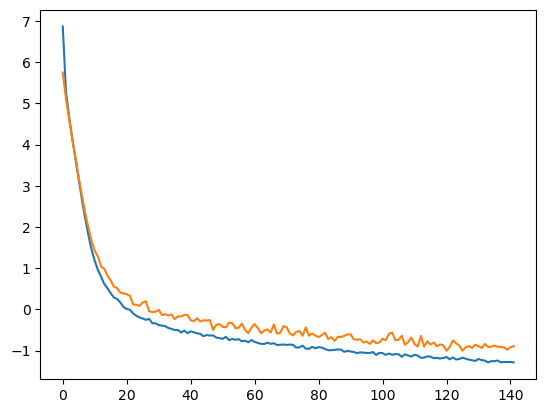

In [20]:
# no mvscale
plt.plot(np.array(data["train"]))
plt.plot(np.array(data["val"]))

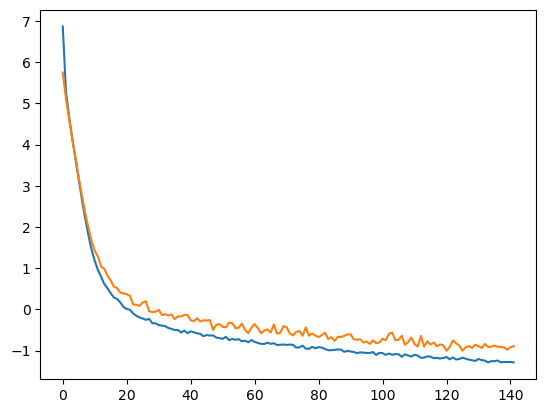

In [21]:
# with mvscale
plt.plot(np.array(data["train"]))
plt.plot(np.array(data["val"]))

In [21]:
# no mvscale
params, static = eqx.partition(fit, eqx.is_array)
float(FisherLoss()(params, static, points))

4.482579245756131

In [23]:
# with mvscale
params, static = eqx.partition(fit, eqx.is_array)
float(FisherLoss()(params, static, points[1::]))

-1.0835838525879362

In [32]:
train_key, train_key_item = jax.random.split(train_key)
fit2, data = flowjax.train.fit_to_data(
    key=train_key_item,
    dist=fit,
    x=points[:100],
    batch_size=8,
    learning_rate=5e-4,
    max_epochs=800,
    max_patience=20,
    loss_fn=FisherLoss(),
)

  4%|▎         | 29/800 [00:08<03:47,  3.39it/s, train=-1.9743701461152876, val=0.6079094283131529 (Max patience reached)]


In [33]:
params, static = eqx.partition(fit2, eqx.is_array)
FisherLoss()(params, static, points)

Array(3.82515079, dtype=float64)

In [34]:
train_key, train_key_item = jax.random.split(train_key)
fit3, data = flowjax.train.fit_to_data(
    key=train_key_item,
    dist=fit2,
    x=points[:100],
    batch_size=64,
    learning_rate=1e-3,
    max_epochs=800,
    max_patience=20,
    loss_fn=FisherLoss(),
)

  3%|▎         | 24/800 [00:05<03:09,  4.09it/s, train=-3.6435790408827886, val=-0.9781785022085058 (Max patience reached)]


In [35]:
params, static = eqx.partition(fit3, eqx.is_array)
FisherLoss()(params, static, points)

Array(3.82811911, dtype=float64)

In [88]:
fit = fit3

In [24]:
sample_key, key = jax.random.split(key)
samples = fit.sample(sample_key, (6000,))

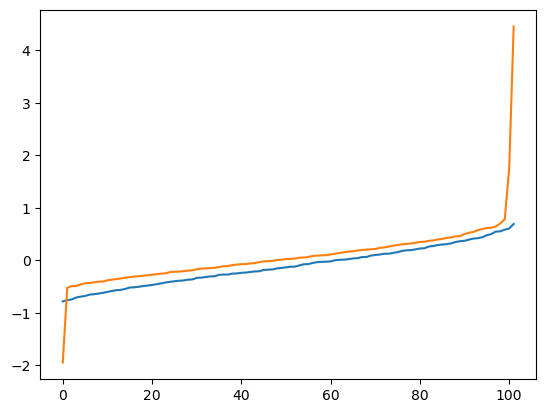

In [25]:
plt.plot(np.log(linalg.eigvalsh(np.cov(draws.T), np.cov(samples.T))))
plt.plot(np.log(linalg.eigvalsh(np.cov(draws.T), np.diag(diag ** 2))))

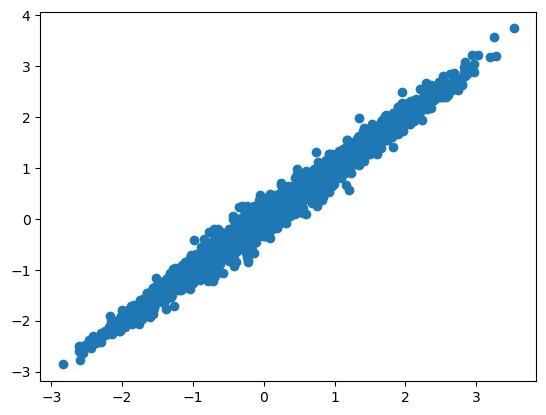

In [26]:
plt.scatter(draws[:, 0], draws[:, 2:].mean(1))

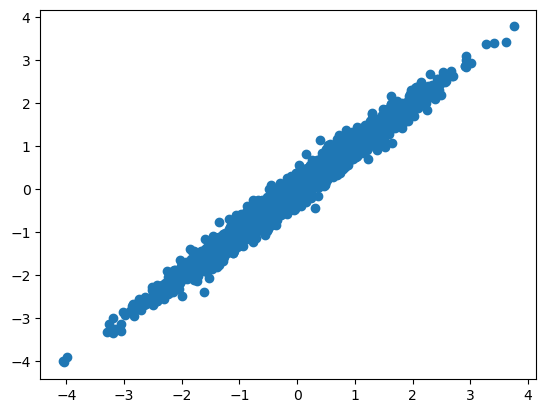

In [27]:
plt.scatter(samples[:, 0], samples[:, 2:].mean(1))

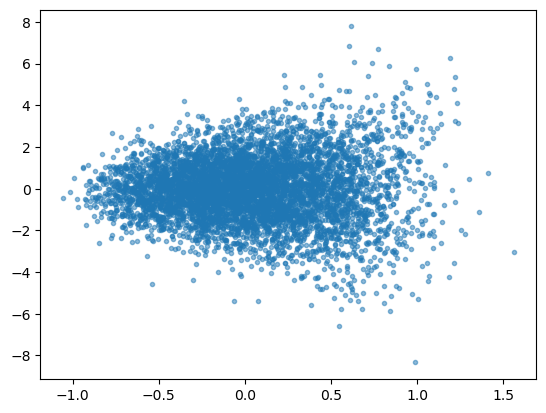

In [28]:
i = 1
j = -1
plt.scatter(samples[:, i], samples[:, j], alpha=0.5, marker=".")
#plt.scatter(draws[i], draws[j], alpha=0.5, marker=".")
#plt.xlim((-40, 40))

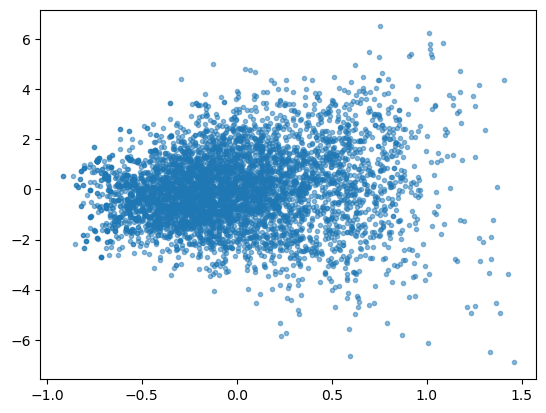

In [29]:
plt.scatter(draws[:, i], draws[:, j], alpha=0.5, marker=".")

In [30]:
draws_trafo = jax.vmap(fit.bijection.inverse, in_axes=[0])(draws)

In [31]:
vals, vecs = linalg.eigh(np.cov(draws_trafo.T))

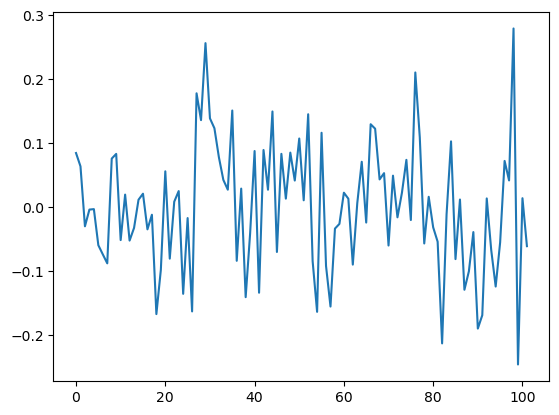

In [32]:
plt.plot(vecs[:, -1])

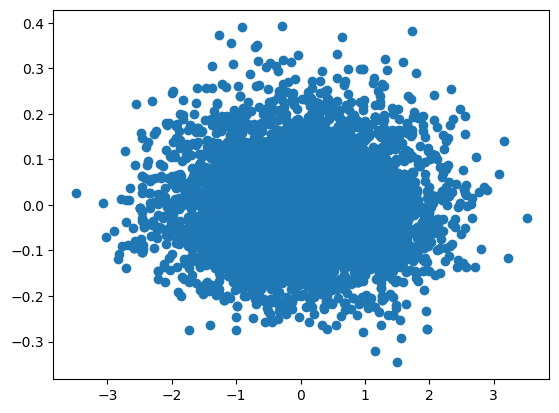

In [33]:
plt.scatter(draws_trafo[:, 0], draws_trafo[:, 1:].mean(1))

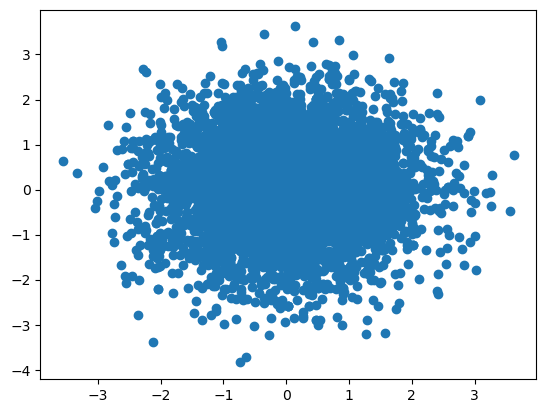

In [34]:
plt.scatter(draws_trafo[:, 1], draws_trafo[:, 10])

<Axes: ylabel='Density'>

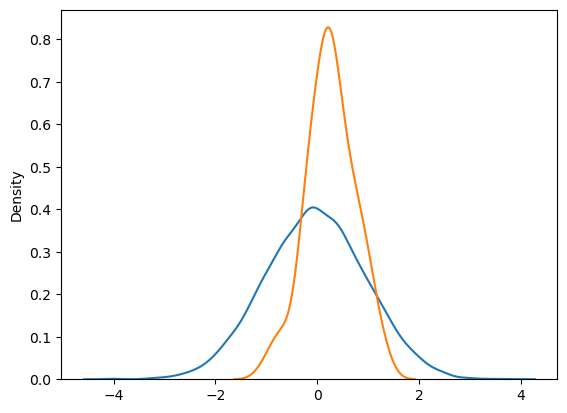

In [35]:
sns.kdeplot(samples[:, 0])
sns.kdeplot(draws[0])

In [36]:
compiled2 = normalize_model(compiled, fit)

In [38]:
trace2 = nutpie.sample(
    compiled2,
    chains=5,
    store_gradient=True,
    store_unconstrained=True,
    store_mass_matrix=True,
    seed=1234,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,1,0.51,7
,1300,0,0.50,7
,1300,0,0.52,7
,1300,0,0.54,7
,1300,0,0.51,7


In [39]:
arviz.ess(trace.sample_stats.unconstrained_draw)

<xarray.Dataset> Size: 2kB
Dimensions:                  (unconstrained_parameter: 102)
Coordinates:
  * unconstrained_parameter  (unconstrained_parameter) object 816B 'mu' ... '...
Data variables:
    unconstrained_draw       (unconstrained_parameter) float64 816B 32.67 ......

In [40]:
arviz.ess(trace2.sample_stats.unconstrained_draw).min()

<xarray.Dataset> Size: 8B
Dimensions:             ()
Data variables:
    unconstrained_draw  float64 8B 1.987e+03

In [41]:
points2, draws2, grads2 = unnormalize_points(trace2, fit)

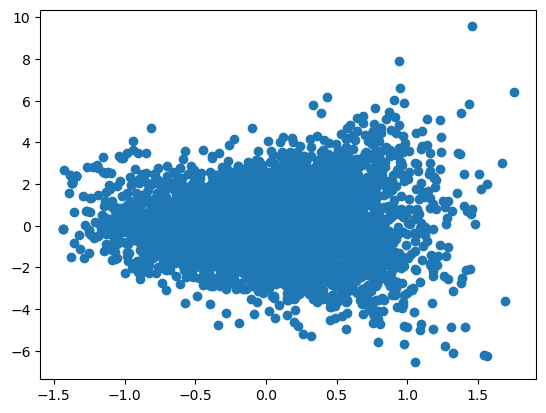

In [42]:
plt.scatter(draws2[:, 1], draws2[:, -1])

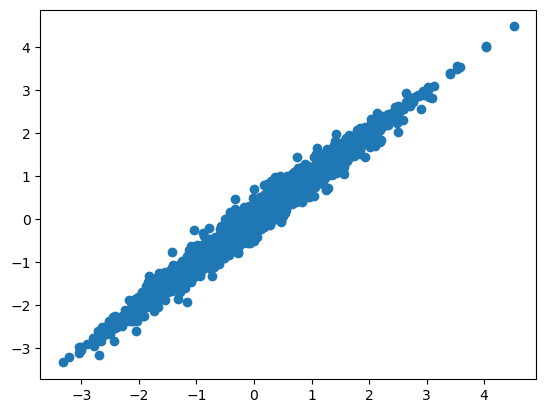

In [43]:
plt.scatter(draws2[:, 0], draws2[:, 2:].mean(1))

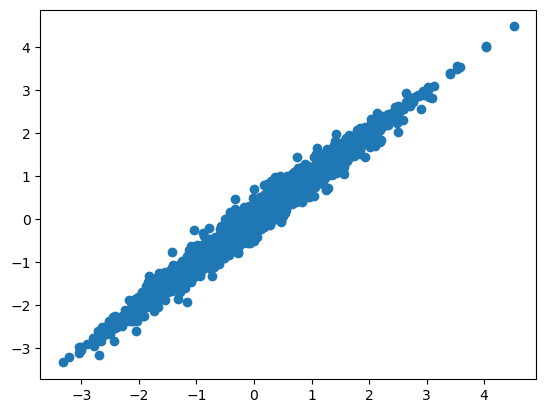

In [44]:
plt.scatter(draws2[:, 0], draws2[:, 2:].mean(1))

In [46]:
fit21, data = flowjax.train.fit_to_data(
    key=train_key,
    dist=fit,
    x=points2[::2],
    batch_size=8,
    learning_rate=1e-3,
    max_epochs=200,
    max_patience=20,
    loss_fn=FisherLoss(),
)

 66%|██████▌   | 132/200 [04:21<02:14,  1.98s/it, train=-1.373366181079845, val=-1.0046895893196928 (Max patience reached)]


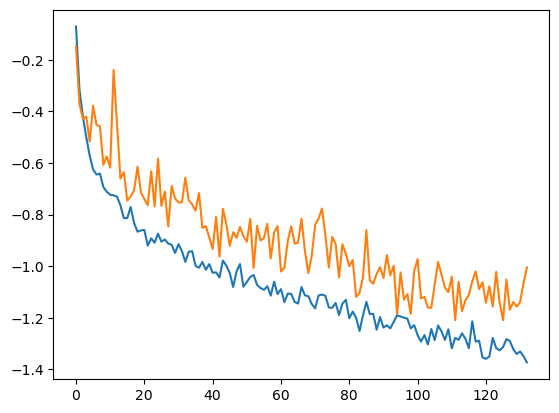

In [48]:
plt.plot(data["train"])
plt.plot(data["val"])

In [51]:
fit22, data = flowjax.train.fit_to_data(
    key=train_key,
    dist=fit21,
    x=points2[::2],
    batch_size=8,
    learning_rate=1e-3,
    max_epochs=200,
    max_patience=20,
    loss_fn=FisherLoss(),
)

 40%|███▉      | 79/200 [02:38<04:03,  2.01s/it, train=-1.4568537614192572, val=-1.2619063170163238 (Max patience reached)]


In [55]:
params, static = eqx.partition(fit, eqx.is_array)
FisherLoss()(params, static, points2[1::])

Array(0.70188985, dtype=float64)

In [56]:
params, static = eqx.partition(fit21, eqx.is_array)
FisherLoss()(params, static, points2[1::])

Array(-1.06874776, dtype=float64)

In [57]:
params, static = eqx.partition(fit22, eqx.is_array)
FisherLoss()(params, static, points2[1::])

Array(-1.19560443, dtype=float64)

In [61]:
compiled3 = normalize_model(compiled, fit22)

trace3 = nutpie.sample(
    compiled3,
    chains=5,
    store_gradient=True,
    store_unconstrained=True,
    store_mass_matrix=True,
    seed=12345,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,2,0.50,7
,1300,0,0.50,7
,1300,0,0.53,7
,1300,1,0.51,7
,1300,0,0.52,7


In [65]:
arviz.ess(trace3.sample_stats.unconstrained_draw).min().unconstrained_draw.values

array(6886.68318987)